In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
from torchvision import transforms as T
from torchvision import io

In [19]:
from matplotlib import pyplot as plt

In [4]:
class ConvNormAct(nn.Module):
    def __init__(self, in_nc, out_nc, stride=1):
        super().__init__()

        self.conv = nn.Conv2d(in_nc, out_nc, 3, stride=stride, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_nc)
        self.act = nn.GELU()

    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = self.act(out)

        return out

class UnetBlock(nn.Module):
    def __init__(self, in_nc, inner_nc, out_nc, inner_block=None):
        super().__init__()

        self.conv1 = ConvNormAct(in_nc, inner_nc, stride=2)
        self.conv2 = ConvNormAct(inner_nc, inner_nc)
        self.inner_block = inner_block
        self.conv3 = ConvNormAct(inner_nc, inner_nc)
        self.conv_cat = nn.Conv2d(inner_nc+in_nc, out_nc, 3, padding=1)

    def forward(self, x):
        _,_,h,w = x.shape

        inner = self.conv1(x)
        inner = self.conv2(inner)
        #print(inner.shape)
        if self.inner_block is not None:
            inner = self.inner_block(inner)
        inner = self.conv3(inner)

        inner = F.upsample(inner, size=(h,w), mode='bilinear')
        # Конкатенация результата внутреннего блока и результата верхнего
        inner = torch.cat((x, inner), axis=1)
        out = self.conv_cat(inner)

        return out

class Unet(nn.Module):
    def __init__(self, in_nc=1, nc=32, out_nc=1, num_downs=6):
        super().__init__()

        self.cna1 = ConvNormAct(in_nc, nc)
        self.cna2 = ConvNormAct(nc, nc)

        unet_block = None
        for i in range(num_downs-3):
            unet_block = UnetBlock(8*nc, 8*nc, 8*nc, unet_block)
        unet_block = UnetBlock(4*nc, 8*nc, 4*nc, unet_block)
        unet_block = UnetBlock(2*nc, 4*nc, 2*nc, unet_block)
        self.unet_block = UnetBlock(nc, 2*nc, nc, unet_block)

        self.cna3 = ConvNormAct(nc, nc)

        self.conv_last = nn.Conv2d(nc, out_nc, 3, padding=1)

    def forward(self, x):
        out = self.cna1(x)
        out = self.cna2(out)
        out = self.unet_block(out)
        out = self.cna3(out)
        out = self.conv_last(out)

        return out

In [6]:
device = 'cuda'

In [7]:
unet_model = Unet(in_nc=3, nc=32, out_nc=1, num_downs=5)
unet_model = unet_model.to(device)

In [9]:
checkpoint_path = 'C:/Users/igors/forest_project/forest_segmentation_model.pth'
checkpoint = torch.load(checkpoint_path)
unet_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [12]:
resize = T.Resize((256, 256))

In [14]:
img = resize(io.read_image('C:/Users/igors/forest_project/Dataset/Forest Segmented/Forest Segmented/images/855_sat_01.jpg')/255)

In [15]:
img = img.unsqueeze(0)

In [16]:
img

tensor([[[[0.2549, 0.1294, 0.2314,  ..., 0.4784, 0.4863, 0.4510],
          [0.2588, 0.1451, 0.2039,  ..., 0.4902, 0.4863, 0.4157],
          [0.2353, 0.2000, 0.3490,  ..., 0.4588, 0.4471, 0.4784],
          ...,
          [0.3412, 0.3020, 0.2157,  ..., 0.3882, 0.4196, 0.3725],
          [0.1725, 0.1804, 0.2157,  ..., 0.3333, 0.2784, 0.2980],
          [0.1647, 0.2078, 0.2078,  ..., 0.2235, 0.2235, 0.2667]],

         [[0.2941, 0.1647, 0.2471,  ..., 0.4784, 0.4824, 0.4471],
          [0.2980, 0.1804, 0.2235,  ..., 0.4902, 0.4824, 0.4118],
          [0.2784, 0.2431, 0.3882,  ..., 0.4510, 0.4471, 0.4784],
          ...,
          [0.3569, 0.3176, 0.2314,  ..., 0.4078, 0.4588, 0.4235],
          [0.2118, 0.2157, 0.2431,  ..., 0.3412, 0.2980, 0.3373],
          [0.2157, 0.2471, 0.2431,  ..., 0.2196, 0.2471, 0.3020]],

         [[0.1608, 0.0431, 0.1569,  ..., 0.3843, 0.4000, 0.3647],
          [0.1647, 0.0588, 0.1333,  ..., 0.3961, 0.4000, 0.3294],
          [0.1451, 0.1176, 0.2902,  ..., 0

In [17]:
with torch.no_grad():
    pred = unet_model(img.cuda())
pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)

C:\Users\igors\PycharmProjects\pythonProject\venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\igors\PycharmProjects\pythonProject\venv\lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


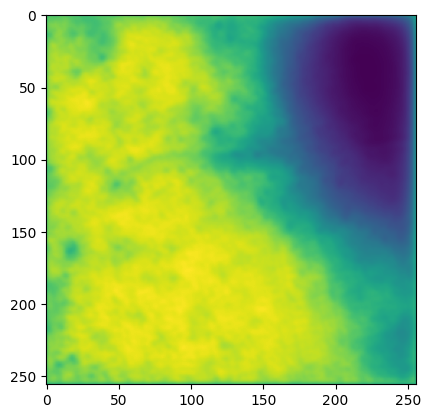

In [20]:
plt.imshow(pred)

In [22]:
img

tensor([[[[0.2549, 0.1294, 0.2314,  ..., 0.4784, 0.4863, 0.4510],
          [0.2588, 0.1451, 0.2039,  ..., 0.4902, 0.4863, 0.4157],
          [0.2353, 0.2000, 0.3490,  ..., 0.4588, 0.4471, 0.4784],
          ...,
          [0.3412, 0.3020, 0.2157,  ..., 0.3882, 0.4196, 0.3725],
          [0.1725, 0.1804, 0.2157,  ..., 0.3333, 0.2784, 0.2980],
          [0.1647, 0.2078, 0.2078,  ..., 0.2235, 0.2235, 0.2667]],

         [[0.2941, 0.1647, 0.2471,  ..., 0.4784, 0.4824, 0.4471],
          [0.2980, 0.1804, 0.2235,  ..., 0.4902, 0.4824, 0.4118],
          [0.2784, 0.2431, 0.3882,  ..., 0.4510, 0.4471, 0.4784],
          ...,
          [0.3569, 0.3176, 0.2314,  ..., 0.4078, 0.4588, 0.4235],
          [0.2118, 0.2157, 0.2431,  ..., 0.3412, 0.2980, 0.3373],
          [0.2157, 0.2471, 0.2431,  ..., 0.2196, 0.2471, 0.3020]],

         [[0.1608, 0.0431, 0.1569,  ..., 0.3843, 0.4000, 0.3647],
          [0.1647, 0.0588, 0.1333,  ..., 0.3961, 0.4000, 0.3294],
          [0.1451, 0.1176, 0.2902,  ..., 0